In [1]:
get_ipython().run_line_magic('matplotlib', 'inline')
import os, sys

# sys.path.append("~/X/PythonForDataScience/air_traffic_project/submissions/first_real_submission/")

import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from problem import *
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, FunctionTransformer
from sklearn.decomposition import PCA
import geopy.distance
from sklearn.metrics import mean_squared_error
from model_selection_python import *
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance


from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import os

from estimator import _merge_external_data
from keras.wrappers.scikit_learn import KerasRegressor

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.models import Sequential
from keras.metrics import RootMeanSquaredError

from xgboost import XGBRegressor
import xgboost as xgb


pd.set_option('display.max_columns', None)

In [2]:
X_train, y_train = get_train_data('..')
X_test, y_test = get_test_data('..')

X_train_merged = _merge_external_data(X_train)
X_test_merged = _merge_external_data(X_test)

/Users/maxime/X/PythonForDataScience/air_traffic_project/src/estimator.py:40: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  X_encoded.loc[:, 'week'] = X_encoded['DateOfDeparture'].dt.week


In [3]:
print(X_train_merged.shape)
print(X_test_merged.shape)
print(X_train_merged.columns)
X_train_merged.head(15)

(8902, 81)
(2226, 81)
Index(['Departure', 'Arrival', 'WeeksToDeparture', 'std_wtd',
       'Days_to_departure', 'route_mean', 'year_departure', 'day_departure',
       'n_days_departure', 'day_nb_mean', 'day_mean', 'week_mean',
       'month_mean', 'oil_stock_price', 'oil_stock_volume', 'AAL_stock_price',
       'AAL_stock_volume', 'SP_stock_price', 'SP_stock_volume',
       'Max TemperatureC_dep', 'Mean TemperatureC_dep', 'Min TemperatureC_dep',
       'Dew PointC_dep', 'MeanDew PointC_dep', 'Min DewpointC_dep',
       'Max Humidity_dep', 'Mean Humidity_dep', 'Min Humidity_dep',
       'Max Sea Level PressurehPa_dep', 'Mean Sea Level PressurehPa_dep',
       'Min Sea Level PressurehPa_dep', 'Max VisibilityKm_dep',
       'Mean VisibilityKm_dep', 'Min VisibilitykM_dep',
       'Max Wind SpeedKm/h_dep', 'Mean Wind SpeedKm/h_dep', 'CloudCover_dep',
       'WindDirDegrees_dep', 'LoadFactorDomestic_dep',
       'PassengersDomestic_dep', 'latitude_deg_dep', 'longitude_deg_dep',
       'pop2

,Departure,Arrival,WeeksToDeparture,std_wtd,Days_to_departure,route_mean,year_departure,day_departure,n_days_departure,day_nb_mean,day_mean,week_mean,month_mean,oil_stock_price,oil_stock_volume,AAL_stock_price,AAL_stock_volume,SP_stock_price,SP_stock_volume,Max TemperatureC_dep,Mean TemperatureC_dep,Min TemperatureC_dep,Dew PointC_dep,MeanDew PointC_dep,Min DewpointC_dep,Max Humidity_dep,Mean Humidity_dep,Min Humidity_dep,Max Sea Level PressurehPa_dep,Mean Sea Level PressurehPa_dep,Min Sea Level PressurehPa_dep,Max VisibilityKm_dep,Mean VisibilityKm_dep,Min VisibilitykM_dep,Max Wind SpeedKm/h_dep,Mean Wind SpeedKm/h_dep,CloudCover_dep,WindDirDegrees_dep,LoadFactorDomestic_dep,PassengersDomestic_dep,latitude_deg_dep,longitude_deg_dep,pop2010_dep,UnemploymentRate_dep,holidays_dep,GDP_per_cap_dep,closest_holidays_dep,total_arr,flights_arr,booth_arr,mean_per_flight_arr,Max TemperatureC_arr,Mean TemperatureC_arr,Min TemperatureC_arr,Dew PointC_arr,MeanDew PointC_arr,Min DewpointC_arr,Max Humidity_arr,Mean Humidity_arr,Min Humidity_arr,Max Sea Level PressurehPa_arr,Mean Sea Level PressurehPa_arr,Min Sea Level PressurehPa_arr,Max VisibilityKm_arr,Mean VisibilityKm_arr,Min VisibilitykM_arr,Max Wind SpeedKm/h_arr,Mean Wind SpeedKm/h_arr,CloudCover_arr,WindDirDegrees_arr,LoadFactorDomestic_arr,PassengersDomestic_arr,latitude_deg_arr,longitude_deg_arr,pop2010_arr,UnemploymentRate_arr,holidays_arr,GDP_per_cap_arr,closest_holidays_arr,distance,day_nb
0,ORD,DFW,12.875000,9.812647,90.0,11.919010,2012,19,15510,11.2038,11.080302,11.301741,11.240980,84.029999,109008.000000,12.700000,1.164740e+07,1357.979980,3.815350e+09,35.0,31.0,26.0,20.0,18.0,17.0,62.0,51.0,39.0,1014.0,1012.0,1009.0,16.0,16.0,16.0,37.0,25.0,1.0,208.0,88.14,2480870,41.978600,-87.904800,2697530.0,8.7,True,50304.0,16.0,6599.0,60.0,250.0,109.98,34.0,29.0,24.0,22.0,21.0,19.0,82.0,63.0,44.0,1012.0,1010.0,1009.0,16.0,16.0,16.0,48.0,29.0,5.0,161.0,88.65,2276172,32.896801,-97.038002,1200370.0,7.0,True,47417.0,1.0,1290.346797,170
1,LAS,DEN,14.285714,9.466734,100.0,10.451326,2012,10,15593,10.7688,11.316519,11.282255,11.163944,96.540001,221996.000000,12.000000,9.006400e+06,1429.079956,3.223670e+09,36.0,32.0,27.0,16.0,13.0,10.0,51.0,36.0,21.0,1011.0,1009.0,1005.0,16.0,15.0,11.0,32.0,18.0,5.0,187.0,84.68,1500764,36.080101,-115.152000,584606.0,11.8,False,44589.0,8.0,848.0,8.0,28.0,106.00,33.0,25.0,16.0,-2.0,-6.0,-8.0,21.0,14.0,7.0,1011.0,1008.0,1005.0,16.0,16.0,16.0,35.0,15.0,3.0,207.0,85.74,2073285,39.861698,-104.672997,603354.0,8.0,False,49254.0,8.0,1011.046677,253
2,DEN,LAX,10.863636,9.035883,76.0,11.049831,2012,5,15618,11.5286,11.221390,11.210159,11.243521,89.879997,279131.000000,11.660000,6.819600e+06,1460.930054,3.172940e+09,6.0,2.0,-1.0,0.0,-2.0,-4.0,92.0,76.0,60.0,1027.0,1023.0,1020.0,16.0,9.0,1.0,27.0,15.0,7.0,357.0,87.27,2136379,39.861698,-104.672997,603354.0,7.9,False,49254.0,4.0,19164.0,95.0,852.0,201.73,22.0,19.0,16.0,17.0,16.0,14.0,93.0,77.0,61.0,1018.0,1016.0,1014.0,16.0,13.0,8.0,24.0,8.0,5.0,266.0,84.94,1872910,33.942501,-118.407997,3795370.0,10.1,False,51871.0,4.0,1387.023784,278
3,ATL,ORD,11.480000,7.990202,80.0,11.300291,2011,9,15256,11.2015,10.812631,11.210159,11.243521,84.600004,302396.666667,5.290000,4.963567e+06,1181.746664,4.824660e+09,22.0,19.0,16.0,12.0,10.0,6.0,67.0,56.0,44.0,1026.0,1024.0,1021.0,16.0,16.0,16.0,37.0,26.0,8.0,70.0,85.20,3511352,33.636700,-84.428101,429193.0,10.2,False,42029.0,2.0,12806.0,69.0,349.0,185.59,27.0,19.0,11.0,12.0,10.0,9.0,83.0,58.0,33.0,1028.0,1026.0,1024.0,16.0,16.0,16.0,23.0,6.0,1.0,93.0,86.55,2417073,41.978600,-87.904800,2697530.0,10.1,False,50304.0,2.0,974.957144,282
4,DEN,SFO,11.450000,9.517159,80.0,10.822171,2012,21,15391,11.3304,11.080302,10.950214,10.926466,105.839996,316239.000000,7.890000,1.533480e+07,1362.209961,3.795200e+09,8.0,2.0,-4.0,-6.0,-9.0,-13.0,46.0,39.0,31.0,1012.0,1008.0,1004.0,16.0,16.0,16.0,61.0,30.0,5.0,270.0,80.36,1746327,39.861698,-104.672997,603354.0,7.8,True,49254.0,2.0,8109.0,43.0,316.0,188.58,16.0,12.0,8.0

In [4]:
X_train_merged.drop(['Departure', 'Arrival', 'closest_holidays_arr', 'closest_holidays_dep'], axis=1, inplace=True)
X_test_merged.drop(['Departure', 'Arrival', 'closest_holidays_arr', 'closest_holidays_dep'], axis=1, inplace=True)

## Testing Without External Variables

In [5]:
# features = ['WeeksToDeparture', 'oil_stock_volume',
#                     'AAL_stock_price', 'AAL_stock_volume', 'SP_stock_price', 'SP_stock_volume',
#                     'latitude_deg_dep', 'longitude_deg_dep', 'pop2010_dep', 
#                     'latitude_deg_arr', 'longitude_deg_arr', 'pop2010_arr', 'distance',
#                     'LoadFactorDomestic_arr', 'PassengersDomestic_arr',
#                     'GDP_per_cap_dep', 'GDP_per_cap_arr', 'UnemploymentRate_dep', 'UnemploymentRate_arr', 
#                     'day_departure', 'n_days_departure', 'Max TemperatureC_dep', 
#             'Max TemperatureC_arr']

# features_to_keep = ['WeeksToDeparture', 'oil_stock_volume',
#                     'AAL_stock_price', 'AAL_stock_volume', 'SP_stock_price', 'SP_stock_volume', 'distance',
#                     'UnemploymentRate_dep', 'UnemploymentRate_arr', 
#                     'day_departure', 'n_days_departure', 'Max TemperatureC_dep', 
#                     'Max TemperatureC_arr', 'route_mean', 'day_nb_mean', 'day_mean', 'week_mean', 'month_mean']

features_to_keep = ['WeeksToDeparture', 'week_mean', 'day_mean', 'month_mean', 'day_nb_mean', 
                   'route_mean', 'std_wtd', 'n_days_departure']

X_train_data = X_train_merged[features_to_keep]
X_test_data = X_test_merged[features_to_keep]
print(X_train_data.shape)
print(X_test_data.shape)

(8902, 8)
(2226, 8)


In [6]:
grid_params = {
    'n_estimators': [100],
    'min_samples_split': [0.001],
    'oob_score': [True],
    'max_features': [0.5, 0.6, 0.75]
}

gs = GridSearchCV(estimator=RandomForestRegressor(),
                  param_grid=grid_params,
                  n_jobs=-1,
                  cv=5,
                  verbose=0)

gs.fit(X_train_data, y_train)        
print(gs.best_score_)
print(gs.best_params_) 

0.8389217293319591
{'max_features': 0.75, 'min_samples_split': 0.001, 'n_estimators': 100, 'oob_score': True}


In [7]:
# Prediction performance on test set is not as good as on train set
print(X_train_data.shape)
print(X_test_data.shape)
print(y_train.shape)
print(y_test.shape)

score_train = gs.score(X_train_data, y_train)
score_test = gs.score(X_test_data, y_test)

rmse_train = mean_squared_error(y_train, gs.predict(X_train_data), squared=False)
rmse_test = mean_squared_error(y_test, gs.predict(X_test_data), squared=False)

print(f"Training RMSE: {rmse_train} and Score: {score_train}")
print(f"Testing RMSE: {rmse_test} and Score: {score_test}")

(8902, 8)
(2226, 8)
(8902,)
(2226,)
Training RMSE: 0.22994360540365352 and Score: 0.9464737837113627
Testing RMSE: 0.4073462894029609 and Score: 0.8390082403676778


## Testing With External Variables

In [8]:
# # features_to_keep = ['WeeksToDeparture', 'oil_stock_volume',
# #                     'AAL_stock_price', 'AAL_stock_volume', 'SP_stock_price', 'SP_stock_volume', 'distance',
# #                     'UnemploymentRate_dep', 'UnemploymentRate_arr', 
# #                     'day_departure', 'n_days_departure', 'Max TemperatureC_dep', 
# #                     'Max TemperatureC_arr', 'route_mean', 'day_nb_mean', 'day_mean', 'week_mean', 'month_mean']

features_to_keep = ['WeeksToDeparture', 'std_wtd', 'n_days_departure',
                    'week_mean', 'day_mean', 'month_mean', 'day_nb_mean', 'route_mean',
                    'distance', 'total_arr', 'flights_arr', 'booth_arr', 'mean_per_flight_arr']

X_train_data = X_train_merged[features_to_keep]
X_test_data = X_test_merged[features_to_keep]

# print(X_train_data.isna().sum())

grid_params = {
    'n_estimators': [100],
    'min_samples_split': [0.001, 0.01],
    'oob_score': [False],
    'max_features': [0.5, 0.75, 1]
}

gs = GridSearchCV(estimator=RandomForestRegressor(),
                  param_grid=grid_params,
                  n_jobs=-1,
                  cv=5,
                  verbose=0)

gs.fit(X_train_data, y_train)        
print(gs.best_score_)
print(gs.best_params_)

# Prediction performance on test set is not as good as on train set
# X_test_data = X_test_merged[features_to_keep]
score_train = gs.score(X_train_data, y_train)
score_test = gs.score(X_test_data, y_test)

rmse_train = mean_squared_error(y_train, gs.predict(X_train_data), squared=False)
rmse_test = mean_squared_error(y_test, gs.predict(X_test_data), squared=False)

print(f"Training RMSE: {rmse_train} and Score: {score_train}")
print(f"Testing RMSE: {rmse_test} and Score: {score_test}")

WeeksToDeparture       0
std_wtd                0
n_days_departure       0
week_mean              0
day_mean               0
month_mean             0
day_nb_mean            0
route_mean             0
distance               0
total_arr              0
flights_arr            0
booth_arr              0
mean_per_flight_arr    0
dtype: int64
0.8536921019493272
{'max_features': 0.75, 'min_samples_split': 0.001, 'n_estimators': 100, 'oob_score': False}
Training RMSE: 0.20675240173169132 and Score: 0.9567262035540215
Testing RMSE: 0.3889127052698141 and Score: 0.8532492327698697


In [ ]:
# features_to_keep = ['WeeksToDeparture', 'n_days_departure', '
#                     'oil_stock_volume', 'AAL_stock_price', 'AAL_stock_volume', 'SP_stock_price', 'SP_stock_volume', 'distance',
#                     'UnemploymentRate_dep', 'UnemploymentRate_arr', 
#                     'day_departure', '', 'Max TemperatureC_dep', 'Max TemperatureC_arr',
#                     '', ''
#                     'route_mean', 'day_nb_mean', 'day_mean', 'week_mean', 'month_mean',
#                     'distance', 'total_arr', 'flights_arr', 'booth_arr', 'mean_per_flight_arr']

# X_train_data = X_train_merged[features_to_keep]
# X_test_data = X_test_merged[features_to_keep]

# print(X_train_data.isna().sum())
# print(X_train_data.info())


# grid_params = {
#     'n_estimators': [100],
#     'min_samples_split': [0.001, 0.01],
#     'oob_score': [False],
#     'max_features': [0.5, 0.75, 1]
# }

# gs = GridSearchCV(estimator=RandomForestRegressor(),
#                   param_grid=grid_params,
#                   n_jobs=-1,
#                   cv=5,
#                   verbose=0)

# gs.fit(X_train_data, y_train)        
# print(gs.best_score_)
# print(gs.best_params_)

# # Prediction performance on test set is not as good as on train set
# # X_test_data = X_test_merged[features_to_keep]
# score_train = gs.score(X_train_data, y_train)
# score_test = gs.score(X_test_data, y_test)

# rmse_train = mean_squared_error(y_train, gs.predict(X_train_data), squared=False)
# rmse_test = mean_squared_error(y_test, gs.predict(X_test_data), squared=False)

# print(f"Training RMSE: {rmse_train} and Score: {score_train}")
# print(f"Testing RMSE: {rmse_test} and Score: {score_test}")

## XGBoost feat Sklearn

In [ ]:
import xgboost as xgb

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.1,
               alpha = 10, n_estimators = 100)
xg_reg.fit(X_train_data, y_train)

preds = xg_reg.predict(X_test_data)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

In [ ]:
data_dmatrix = xgb.DMatrix(data=X_train_data,label=y_train)

params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50, early_stopping_rounds=10, metrics="rmse", as_pandas=True, seed=123)
cv_results

In [ ]:
# print((cv_results["test-rmse-mean"]).tail(1))

## Tree Visualisation

In [ ]:
# os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"
# dot_data = StringIO()
# export_graphviz(pipeline[0].estimators_[0], out_file=dot_data)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
# Image(graph.create_png())

# # viz = dtreeviz(forest_estimator.estimators_[0], X_train_data, y_train, feature_names=X_train_data.columns, target_name="Target")
# # viz

### Feature Importance

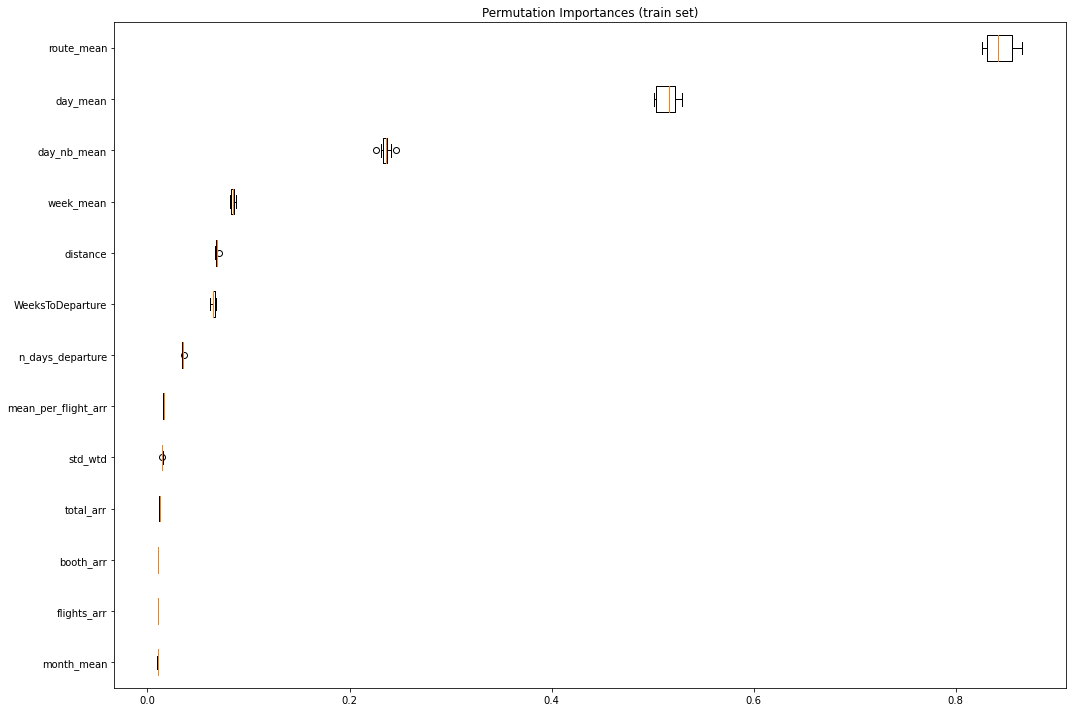

In [9]:
forest_estimator = gs.best_estimator_
pipeline = make_pipeline(forest_estimator)
pipeline.fit(X_train_data, y_train).score(X_test_data, y_test)

feature_importances = permutation_importance(
    pipeline, X_train_data, y_train, n_repeats=10
)

sorted_idx = feature_importances.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(15,10))
ax.boxplot(feature_importances.importances[sorted_idx].T,
           vert=False, labels=X_train_data.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

In [ ]:
feature_importances = permutation_importance(
    pipeline, X_test_data, y_test, n_repeats=10
)

sorted_idx = feature_importances.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(15,10))
ax.boxplot(feature_importances.importances[sorted_idx].T,
           vert=False, labels=X_test_data.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [ ]:
# plt.figure(figsize=(30, 30))
# sns.heatmap(abs(Xy_train.corr()), cmap='BrBG', annot=True, vmin=-1, vmax=1)

In [ ]:
# def evaluate(model, test_features, test_labels):
#     predictions = model.predict(test_features)
#     errors = abs(predictions - test_labels)
#     mape = 100 * np.mean(errors / test_labels)
#     accuracy = 100 - mape
#     print('Model Performance')
# #     print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
#     print('Accuracy = {:0.2f}%.'.format(accuracy))
    
#     return accuracy

In [ ]:
# plt.figure(figsize=(8, 15))
# heatmap = sns.heatmap(Xy_train.corr()[['Passengers']].sort_values(by='Passengers', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
# heatmap.set_title('Features Correlating with Sales Price', fontdict={'fontsize':18}, pad=16);

In [ ]:
# from sklearn.neighbors import KNeighborsRegressor

# grid_params = {
#     'n_neighbors': range(1, 200),
#     'weights': ['uniform', 'distance'],
#     'metric': ['euclidean', 'manhattan'],
# }

# gs = GridSearchCV(
#     KNeighborsRegressor(),
#     grid_params,
#     verbose=1,
#     cv=3,
#     n_jobs=-1
# )

# gs_results = gs.fit(X_train, y_train)

In [ ]:
# print(gs_results.best_score_)
# print(gs_results.best_estimator_)
# print(gs_results.best_params_)

In [ ]:
# X_train, y_train = problem.get_train_data('..')

In [ ]:

# grid_params = {
#     'randomforestregressor__n_estimators': [50, 100],
#     'randomforestregressor__max_features': ['auto', 'sqrt', 'log2'],
#     'randomforestregressor__max_depth': [4, 6, 8],
#     'randomforestregressor__criterion': ['mse']
# }

# # pipe = make_pipeline(StandardScaler(with_mean=False), RandomForestRegressor())

# gs = GridSearchCV(
#     pipe,
#     grid_params,
#     verbose=1,
#     cv=3,
#     n_jobs=-1
# )

# gs_results = gs.fit(X_train, y_train)

In [ ]:
Index(['WeeksToDeparture', 'std_wtd', 'Days_to_departure', 'route_mean',
       'year_departure', 'day_departure', 'n_days_departure', 'day_nb_mean',
       'day_mean', 'week_mean', 'month_mean', 'oil_stock_price',
       'oil_stock_volume', 'AAL_stock_price', 'AAL_stock_volume',
       'SP_stock_price', 'SP_stock_volume', 'Max TemperatureC_dep',
       'Mean TemperatureC_dep', 'Min TemperatureC_dep', 'Dew PointC_dep',
       'MeanDew PointC_dep', 'Min DewpointC_dep', 'Max Humidity_dep',
       'Mean Humidity_dep', 'Min Humidity_dep',
       'Max Sea Level PressurehPa_dep', 'Mean Sea Level PressurehPa_dep',
       'Min Sea Level PressurehPa_dep', 'Max VisibilityKm_dep',
       'Mean VisibilityKm_dep', 'Min VisibilitykM_dep',
       'Max Wind SpeedKm/h_dep', 'Mean Wind SpeedKm/h_dep', 'CloudCover_dep',
       'WindDirDegrees_dep', 'LoadFactorDomestic_dep',
       'PassengersDomestic_dep', 'latitude_deg_dep', 'longitude_deg_dep',
       'pop2010_dep', 'UnemploymentRate_dep', 'holidays_dep',
       'GDP_per_cap_dep', 'closest_holidays_dep', 'total_arr', 'flights_arr',
       'booth_arr', 'mean_per_flight_arr', 'Max TemperatureC_arr',
       'Mean TemperatureC_arr', 'Min TemperatureC_arr', 'Dew PointC_arr',
       'MeanDew PointC_arr', 'Min DewpointC_arr', 'Max Humidity_arr',
       'Mean Humidity_arr', 'Min Humidity_arr',
       'Max Sea Level PressurehPa_arr', 'Mean Sea Level PressurehPa_arr',
       'Min Sea Level PressurehPa_arr', 'Max VisibilityKm_arr',
       'Mean VisibilityKm_arr', 'Min VisibilitykM_arr',
       'Max Wind SpeedKm/h_arr', 'Mean Wind SpeedKm/h_arr', 'CloudCover_arr',
       'WindDirDegrees_arr', 'LoadFactorDomestic_arr',
       'PassengersDomestic_arr', 'latitude_deg_arr', 'longitude_deg_arr',
       'pop2010_arr', 'UnemploymentRate_arr', 'holidays_arr',
       'GDP_per_cap_arr', 'closest_holidays_arr', 'distance', 'day_nb'],
      dtype='object'